Iteration:  0  Error:  29.1014462511
Iteration:  100  Error:  20.9086265635
Iteration:  200  Error:  20.4527019487
Iteration:  300  Error:  20.1177932175
Iteration:  400  Error:  19.7190499632
Iteration:  500  Error:  19.1962051803
Iteration:  600  Error:  18.5578113616
Iteration:  700  Error:  17.8318816406
Iteration:  800  Error:  17.0163389317
Iteration:  900  Error:  16.0272666973
Iteration:  1000  Error:  14.6349030539
Iteration:  1100  Error:  12.494824663


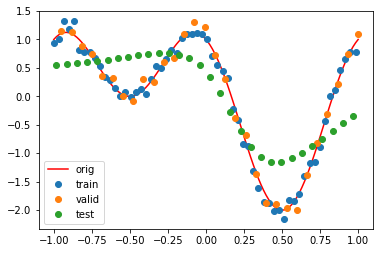

In [3]:
# %load marsland/mlp.py
# The sinewave regression example
import numpy as np

class mlp:
    """ A Multi-Layer Perceptron"""
    
    def __init__(self,inputs,targets,nhidden,beta=1,momentum=0.9,outtype='logistic'):
        """ Constructor """
        # Set up network size
        self.nin = np.shape(inputs)[1]
        self.nout = np.shape(targets)[1]
        self.ndata = np.shape(inputs)[0]
        self.nhidden = nhidden

        self.beta = beta
        self.momentum = momentum
        self.outtype = outtype
    
        # Initialise network
        self.weights1 = (np.random.rand(self.nin+1,self.nhidden)-0.5)*2/np.sqrt(self.nin)
        self.weights2 = (np.random.rand(self.nhidden+1,self.nout)-0.5)*2/np.sqrt(self.nhidden)

    def earlystopping(self,inputs,targets,valid,validtargets,eta,niterations=100):
    
        valid = np.concatenate((valid,-np.ones((np.shape(valid)[0],1))),axis=1)
        
        old_val_error1 = 100002
        old_val_error2 = 100001
        new_val_error = 100000
        
        count = 0
        while (((old_val_error1 - new_val_error) > 0.001) or ((old_val_error2 - old_val_error1)>0.001)):
            count+=1
            print(count)
            self.mlptrain(inputs,targets,eta,niterations)
            old_val_error2 = old_val_error1
            old_val_error1 = new_val_error
            validout = self.mlpfwd(valid, internal=True)
            new_val_error = 0.5*np.sum((validtargets-validout)**2)
            
        print("Stopped", new_val_error,old_val_error1, old_val_error2)
        return new_val_error

    def mlptrain(self,inputs,targets,eta,niterations):
        """ Train the thing """    
        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((np.shape(inputs)[0],1))),axis=1)
        change = range(self.ndata)
    
        updatew1 = np.zeros((np.shape(self.weights1)))
        updatew2 = np.zeros((np.shape(self.weights2)))
            
        for n in range(niterations):
    
            self.outputs = self.mlpfwd(inputs, internal=True)

            error = 0.5*np.sum((self.outputs-targets)**2)
            if (np.mod(n,100)==0):
                print("Iteration: ",n, " Error: ",error)

            # Different types of output neurons
            if self.outtype == 'linear':
                deltao = (self.outputs-targets)/self.ndata
            elif self.outtype == 'logistic':
                deltao = self.beta*(self.outputs-targets)*self.outputs*(1.0-self.outputs)
            elif self.outtype == 'softmax':
                deltao = (self.outputs-targets)*(self.outputs*(-self.outputs)+self.outputs)/self.ndata 
            else:
                print("error")
            
            deltah = self.hidden*self.beta*(1.0-self.hidden)*(np.dot(deltao,np.transpose(self.weights2)))
                      
            updatew1 = eta*(np.dot(np.transpose(inputs),deltah[:,:-1])) + self.momentum*updatew1
            updatew2 = eta*(np.dot(np.transpose(self.hidden),deltao)) + self.momentum*updatew2
            self.weights1 -= updatew1
            self.weights2 -= updatew2
                
            # Randomise order of inputs (not necessary for matrix-based calculation)
            #np.random.shuffle(change)
            #inputs = inputs[change,:]
            #targets = targets[change,:]
            
    def mlpfwd(self,inputs, internal=False):
        """ Run the network forward """

        if not internal:
            inputs = np.concatenate((inputs,-np.ones((np.shape(inputs)[0],1))),axis=1)

        self.hidden = np.dot(inputs,self.weights1)
        self.hidden = 1.0/(1.0+np.exp(-self.beta*self.hidden))
        self.hidden = np.concatenate((self.hidden,-np.ones((np.shape(inputs)[0],1))),axis=1)

        outputs = np.dot(self.hidden,self.weights2)

        # Different types of output neurons
        if self.outtype == 'linear':
            return outputs
        elif self.outtype == 'logistic':
            return 1.0/(1.0+np.exp(-self.beta*outputs))
        elif self.outtype == 'softmax':
            normalisers = np.sum(np.exp(outputs),axis=1)*np.ones((1,np.shape(outputs)[0]))
            return np.transpose(np.transpose(np.exp(outputs))/normalisers)
        else:
            print("error")

    def confmat(self,inputs,targets):
        """Confusion matrix"""

        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((np.shape(inputs)[0],1))),axis=1)
        outputs = self.mlpfwd(inputs)
        
        nclasses = np.shape(targets)[1]

        if nclasses==1:
            nclasses = 2
            outputs = np.where(outputs>0.5,1,0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs,1)
            targets = np.argmax(targets,1)

        cm = np.zeros((nclasses,nclasses))
        for i in range(nclasses):
            for j in range(nclasses):
                cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

        print("Confusion matrix is:")
        print(cm)
        print("Percentage Correct: ",np.trace(cm)/np.sum(cm)*100)


import pylab as pl

# Set up the data
ndata = 120
x = np.linspace(0,1,ndata).reshape((ndata,1))
w = np.sin(2*np.pi*x) + np.cos(4*np.pi*x)
t = np.sin(2*np.pi*x) + np.cos(4*np.pi*x) + np.random.randn(ndata).reshape((ndata,1))*0.1
x = (x-0.5)*2



# Split into training, testing, and validation sets
train = x[0::2,:]
test = x[1::4,:]
valid = x[3::4,:]
traintarget = t[0::2,:]
testtarget = t[1::4,:]
validtarget = t[3::4,:]


# Plot the data
pl.plot(x, w, '-r', label='orig')
pl.plot(train, traintarget ,'o', label='train')
# pl.plot(test, testtarget ,'o', label='test')
pl.plot(valid, validtarget ,'o', label='valid')



# Perform basic training with a small MLP
net = mlp(train,traintarget,3,outtype='linear')
net.mlptrain(train,traintarget,0.05,ndata*10)

# Use early stopping
# net.earlystopping(train,traintarget,valid,validtarget,0.25)

o = net.mlpfwd(test)
pl.plot(test, o ,'o', label='test')

pl.legend(loc='lower left')
# pl.xlabel('x')
# pl.ylabel('t')

# Test out different sizes of network
#count = 0
#out = zeros((10,7))
#for nnodes in [1,2,3,5,10,25,50]:
#    for i in range(10):
#        net = mlp.mlp(train,traintarget,nnodes,outtype='linear')
#        out[i,count] = net.earlystopping(train,traintarget,valid,validtarget,0.25)
#    count += 1
#    
#test = concatenate((test,-ones((shape(test)[0],1))),axis=1)
#outputs = net.mlpfwd(test)
#print 0.5*sum((outputs-testtarget)**2)
#
#print out
#print out.mean(axis=0)
#print out.var(axis=0)
#print out.max(axis=0)
#print out.min(axis=0)

pl.show()
